# andre marroquin
# rodrigo mansilla
# sergio orellana 
# carlos valladares

# Proyecto 2 — Data Science
### link repo: https://github.com/mar22266/PY2-DS/tree/Resultados-Parciales-y-Visualizaciones-Est%C3%A1ticas

branch: Resultados Parciales y Visualizaciones Estáticas

## Fase 2: Investigación de modelos, selección, entrenamiento, evaluación y discusión

**Reto:** CGIAR – Ojos en el Terreno (detección de daños en cultivos)

**Objetivo de esta fase.** Partiendo del EDA, investigar algoritmos, seleccionar candidatos, construir varios modelos que predigan `EXTENT` (severidad % por fila (ID, DAMAGE)), evaluarlos con métricas apropiadas para **regresión**, comparar resultados, justificar la selección final y generar visualizaciones estáticas.

**Tarea de modelado.** Cada fila representa un par `(ID, DAMAGE)` con metadatos (`season`, `growth_stage`, `filename`) y el objetivo `EXTENT` (0–100 en train; ausente en test). En test se debe predecir `EXTENT` por fila, y luego formatear el archivo de envío siguiendo `SampleSubmission.csv`.


## Configuración, imports y utilidades

In [ ]:
# importaciones de librerias
from __future__ import annotations

import os
from pathlib import Path
import re
import json
import warnings
from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# Rutas
DATA_DIR = Path(".")
TRAIN_CSV = DATA_DIR / "Train.csv"
TEST_CSV = DATA_DIR / "Test.csv"
SAMPLE_CSV = DATA_DIR / "SampleSubmission.csv"

OUTPUT_DIR = Path("./outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

plt.rcParams["figure.dpi"] = 120
plt.rcParams["savefig.bbox"] = "tight"

print("RUTAS OK:", TRAIN_CSV.exists(), TEST_CSV.exists(), SAMPLE_CSV.exists())


RUTAS OK: True True True


## Selección de algoritmos a probar (justificación)

Como la variable objetivo `EXTENT` es **continua (0–100)** por `(ID, DAMAGE)`, se plantean **modelos de regresión tabular** con metadatos y rasgos derivados del `filename`:

1) **Ridge Regression** (lineal regularizada): buen baseline, interpretable; sirve para detectar relaciones lineales tras one-hot y scaling.  
2) **Random Forest Regressor**: no lineal, robusto a outlier*, captura interacciones y no exige scaling.  
3) **HistGradientBoostingRegressor** (sklearn): *boosting* eficiente, suele mejorar MAE/RMSE en tabular con variables categóricas codificadas.

Todos evaluados con **GroupKFold por `ID`** para evitar *leakage* entre filas del mismo ID (pues cada imagen aporta varias filas, una por `DAMAGE`).



## Carga y verificación de datos

In [2]:
train = pd.read_csv(TRAIN_CSV)
test = pd.read_csv(TEST_CSV)
sample = pd.read_csv(SAMPLE_CSV)

print(train.head(3))
print(test.head(3))
print(sample.head(3))
print("shapes:", train.shape, test.shape, sample.shape)


              ID                        filename growth_stage damage  extent  \
0  ID_1S8OOWQYCB  L427F01330C01S03961Rp02052.jpg            S     WD       0   
1  ID_0MD959MIZ0      L1083F00930C39S12674Ip.jpg            V      G       0   
2  ID_JRJCI4Q11V      24_initial_1_1463_1463.JPG            V      G       0   

   season  
0  SR2020  
1  SR2021  
2  LR2020  
              ID                         filename growth_stage damage  season
0  ID_ROOWKB90UZ   L122F00315C01S02151Rp04021.jpg            V     WD  SR2020
1  ID_PTEDRY0CYM  L1089F03254C01S08845Rp25119.jpg            F     WD  LR2021
2  ID_5WJXDV96R4   L365F01913C39S12578Rp42918.jpg            V     WD  SR2021
              ID  extent
0  ID_KJ12GE2U80       0
1  ID_W33POE3DBX       0
2  ID_1DZ7VKQTS9       0
shapes: (26068, 6) (8663, 5) (8663, 2)


## Preprocesamiento columnas, mapeos, features

In [3]:
# Normaliza códigos de temporada
def normalize_season(s: str) -> str:
    if pd.isna(s): 
        return "UNKNOWN"
    t = str(s).upper().strip().replace(" ", "")
    t = re.sub(r"[^A-Z0-9]", "", t)
    return t

_STAGE_MAP = {
    "F": "F", "FLOWERING": "F",
    "M": "M", "MATURITY": "M",
    "S": "S", "SOWING": "S",
    "V": "V", "VEGETATIVE": "V"
}

# Normaliza códigos de etapa de crecimiento
def normalize_stage(s: str) -> str:
    if pd.isna(s): 
        return "UNK"
    t = str(s).upper().strip()
    return _STAGE_MAP.get(t, t if t in {"F","M","S","V"} else "UNK")

def filename_features(fname: str) -> Dict[str, str|int]:
    """
    Heurística ligera para extraer rasgos del 'filename':
    - prefijos con L###F####C##S#####...
    - números grandes como proxy de sitio/cámara/posición
    """
    d = {"has_jpg": 0, "has_jpeg": 0, "len_name": 0, "digits_sum": 0}
    if not isinstance(fname, str):
        return d
    name = fname.strip()
    d["has_jpg"] = int(name.lower().endswith(".jpg"))
    d["has_jpeg"] = int(name.lower().endswith(".jpeg"))
    d["len_name"] = len(name)
    digits = re.findall(r"\d+", name)
    d["digits_sum"] = int(np.sum([int(x) for x in digits])) if digits else 0
    return d

# Aplicar preprocesamiento a DataFrame
def apply_preprocessing(df: pd.DataFrame, is_train: bool) -> pd.DataFrame:
    out = df.copy()

    # Asegurar columnas esperadas
    expected = {"ID","filename","growth_stage","damage","season"}
    missing = expected - set(out.columns.str.lower())
    # Normaliza nombres
    out.columns = [c.lower() for c in out.columns]
    # Re-chequeo
    if not {"id","filename","growth_stage","damage","season"}.issubset(set(out.columns)):
        raise ValueError("Faltan columnas clave después de normalizar nombres.")

    # Normalizaciones
    out["season"] = out["season"].map(normalize_season)
    out["stage_code"] = out["growth_stage"].map(normalize_stage)
    out["damage"] = out["damage"].astype(str).str.upper().str.strip()

    # EXTENT: si existe, asegurar rango 0..100
    if "extent" in out.columns:
        out["extent"] = pd.to_numeric(out["extent"], errors="coerce").fillna(0.0).clip(0, 100)

    # Rasgos del filename
    feats = out["filename"].apply(filename_features).apply(pd.Series)
    out = pd.concat([out, feats], axis=1)

    # Mantener solo columnas útiles
    keep_cols = ["id","damage","season","stage_code","has_jpg","has_jpeg","len_name","digits_sum"]
    if "extent" in out.columns:
        keep_cols.append("extent")
    return out[keep_cols]

train_clean = apply_preprocessing(train, is_train=True)
test_clean  = apply_preprocessing(test,  is_train=False)

print(train_clean.head(3))
print(test_clean.head(3))


              id damage  season stage_code  has_jpg  has_jpeg  len_name  \
0  ID_1S8OOWQYCB     WD  SR2020          S        1         0        30   
1  ID_0MD959MIZ0      G  SR2021          V        1         0        26   
2  ID_JRJCI4Q11V      G  LR2020          V        1         0        26   

   digits_sum  extent  
0        7771       0  
1       14726       0  
2        2951       0  
              id damage  season stage_code  has_jpg  has_jpeg  len_name  \
0  ID_ROOWKB90UZ     WD  SR2020          V        1         0        30   
1  ID_PTEDRY0CYM     WD  LR2021          F        1         0        31   
2  ID_5WJXDV96R4     WD  SR2021          V        1         0        30   

   digits_sum  
0        6610  
1       38308  
2       57813  


## Partición con GroupKFold (evitar leakage por ID)


In [4]:
# Preparar datos para modelado
X_cols_cat = ["damage","season","stage_code"]
X_cols_num = ["has_jpg","has_jpeg","len_name","digits_sum"]
y_col = "extent"

# asseertions
assert y_col in train_clean.columns, "La columna 'extent' debe existir en train."

# limpiar datos
X = train_clean[X_cols_cat + X_cols_num].copy()
y = train_clean[y_col].copy()
groups = train_clean["id"].astype(str).values  

gkf = GroupKFold(n_splits=5)
fold_indices = list(gkf.split(X, y, groups=groups))
print("FOLDS:", len(fold_indices))


FOLDS: 5


## Definición de pipelines y grillas de tuning

In [5]:
# definición de pipelines y grillas de tuning

# categorica y numerica
categorical = X_cols_cat
numeric = X_cols_num

pre = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", Pipeline([("scaler", StandardScaler())]), numeric),
    ],
    remainder="drop",
)

# modelos
models = {
    "ridge": Pipeline([
        ("pre", pre),
        ("est", Ridge(random_state=RANDOM_SEED))
    ]),
    "rf": Pipeline([
        ("pre", pre),
        ("est", RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1))
    ]),
    "hgb": Pipeline([
        ("pre", pre),
        ("est", HistGradientBoostingRegressor(random_state=RANDOM_SEED))
    ]),
}

# grillas de hiperparámetros
param_grids = {
    "ridge": {
        "est__alpha": [0.1, 1.0, 3.0, 10.0]
    },
    "rf": {
        "est__n_estimators": [200, 400],
        "est__max_depth": [None, 12, 20],
        "est__min_samples_leaf": [1, 3, 5]
    },
    "hgb": {
        "est__learning_rate": [0.05, 0.1],
        "est__max_depth": [None, 6, 10],
        "est__max_leaf_nodes": [31, 63],
        "est__l2_regularization": [0.0, 0.1]
    },
}


## Entrenamiento con cv (MAE, RMSE, R²) y ranking de modelos

In [ ]:
# entrenamiento con cv por grupos y evaluación
def eval_metrics(y_true, y_pred) -> dict:
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

rows_train = []
rows_cv = []
best_per_model = {}

for name, pipe in models.items():
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[name],
        scoring="neg_mean_absolute_error",
        cv=fold_indices,            
        n_jobs=-1,
        refit=True,
        verbose=0,
    )
    grid.fit(X, y)
    best_per_model[name] = grid.best_estimator_

    # metricas cc
    cv_mae = -grid.best_score_
    rows_cv.append({"model": name, "cv_mae": cv_mae, "best_params": json.dumps(grid.best_params_)})

    # solo para diagnóstico metricas en train
    y_pred_train = grid.predict(X)
    m_train = eval_metrics(y, y_pred_train)
    m_train.update({"model": name})
    rows_train.append(m_train)

# guardar resultados
metrics_cv_df = pd.DataFrame(rows_cv).sort_values("cv_mae")
metrics_cv_df.to_csv(OUTPUT_DIR / "model_metrics_cv.csv", index=False)

metrics_train_df = pd.DataFrame(rows_train).sort_values("MAE")
metrics_train_df.to_csv(OUTPUT_DIR / "model_metrics_train.csv", index=False)

metrics_cv_df  # usa esta tabla para ranking y discusión


,model,cv_mae,best_params
1,rf,3.003015,"{""est__max_depth"": 12, ""est__min_samples_leaf""..."
2,hgb,3.050971,"{""est__l2_regularization"": 0.1, ""est__learning..."
0,ridge,4.524753,"{""est__alpha"": 0.1}"


## Visualización barra comparativa de métricas

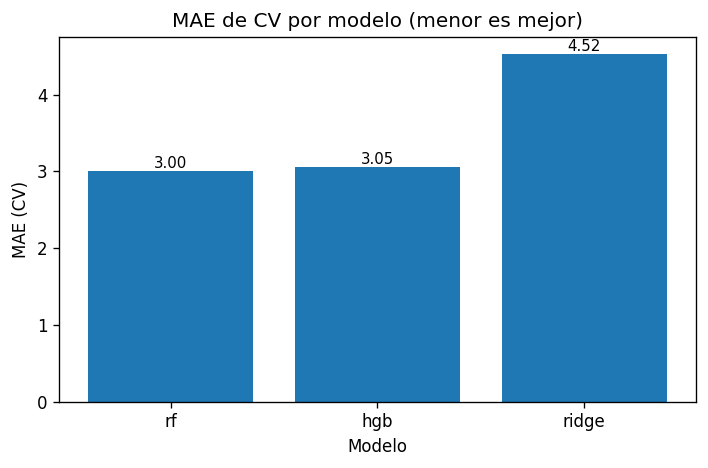

In [ ]:
# grafico de MAE de CV por modelo
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(metrics_cv_df["model"], metrics_cv_df["cv_mae"])
ax.set_title("MAE de CV por modelo (menor es mejor)")
ax.set_xlabel("Modelo")
ax.set_ylabel("MAE (CV)")
for i, v in enumerate(metrics_cv_df["cv_mae"].values):
    ax.text(i, v, f"{v:.2f}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "viz_cv_mae_por_modelo.png")
plt.show()


## Visualización dispersión y línea ideal

MEJOR MODELO (CV): rf


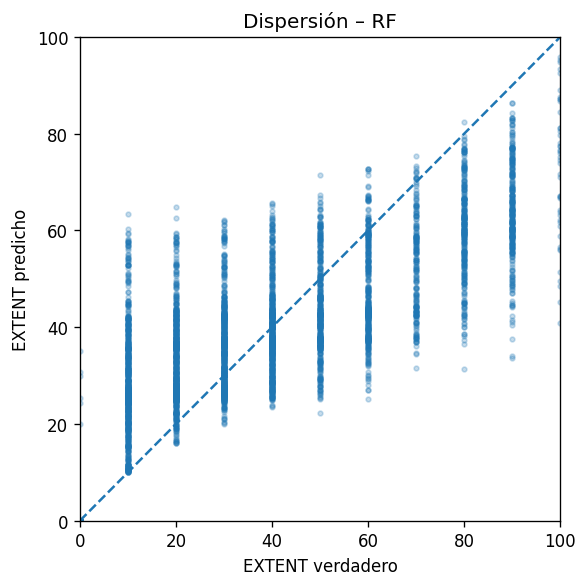

In [ ]:

# selección del mejor modelo y visualización de dispersión
assert 'metrics_cv_df' in globals(), "Falta 'metrics_cv_df'. Ejecuta la celda de CV primero."

best_name = str(metrics_cv_df.iloc[0]['model'])
best_model = best_per_model[best_name]
print("MEJOR MODELO (CV):", best_name)

# visualización de dispersión del mejor modelo
y_true_vec = y.to_numpy().ravel()
y_pred_vec = best_model.predict(X).ravel()

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(y_true_vec, y_pred_vec, alpha=0.25, s=8)

lims = [0, 100]
ax.plot(lims, lims, linestyle="--")
ax.set_xlim(lims); ax.set_ylim(lims)
ax.set_xlabel("EXTENT verdadero")
ax.set_ylabel("EXTENT predicho")
ax.set_title(f"Dispersión – {best_name.upper()}")

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "viz_scatter_true_vs_pred.png")
plt.show()


## Importancias si el mejor es árbol/boosting

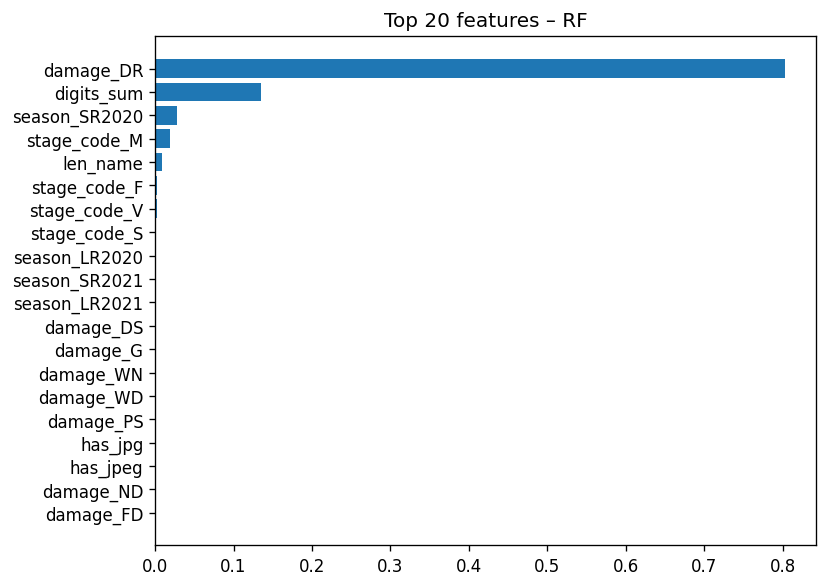

In [ ]:
# imporancia de características solo para modelos de árbol
# Funciona con tu ColumnTransformer pre y modelos de árbol con feature_importances
def get_feature_names_from_pre(pre: ColumnTransformer):
    feature_names = []
    for name, trans, cols in pre.transformers_:
        if name == "remainder" and trans == "drop":
            continue
        # OneHotEncoder en cat
        if isinstance(trans, OneHotEncoder):
            feature_names.extend(list(trans.get_feature_names_out(cols)))
        # Pipeline numérico 
        elif hasattr(trans, "named_steps"):
            feature_names.extend(cols)
        else:
            try:
                feature_names.extend(list(trans.get_feature_names_out(cols)))
            except Exception:
                feature_names.extend(cols if isinstance(cols, list) else [cols])
    return feature_names

# Solo si el mejor modelo es RF o HGB
if best_name in {"rf", "hgb"}:
    pre = best_model.named_steps["pre"]
    est = best_model.named_steps["est"]
    feat_names = get_feature_names_from_pre(pre)
    importances = getattr(est, "feature_importances_", None)

    if importances is None:
        print("El mejor modelo no expone importancias directas.")
    else:
        n = min(len(feat_names), len(importances))
        imp_df = (pd.DataFrame({"feature": feat_names[:n],
                                "importance": np.asarray(importances)[:n]})
                  .sort_values("importance", ascending=False)
                  .head(20))
        imp_df.to_csv(OUTPUT_DIR / "feature_importances_top20.csv", index=False)

        fig, ax = plt.subplots(figsize=(7, 5))
        ax.barh(imp_df["feature"][::-1], imp_df["importance"][::-1])
        ax.set_title(f"Top 20 features – {best_name.upper()}")
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / "viz_feature_importances.png")
        plt.show()
# ekse el mejor modelo no es RF o HG
else:
    print("El mejor modelo no es de árbol/boosting; importancias no aplican.")


## Entrenar en todo el train y predecir test con post-processing

In [ ]:
# elegir el mejor nomrbre y modelo
best_name = str(metrics_cv_df.iloc[0]['model'])
best_model = best_per_model[best_name]
print("MEJOR MODELO (CV):", best_name)

best_model.fit(X, y)

# Preparar X_test y predecir
X_test = test_clean[X_cols_cat + X_cols_num].copy()
y_test_pred = best_model.predict(X_test)

# Post-procesamiento redondeo a múltiplos de 10 opcional
def clip_and_round(x: np.ndarray, do_round_to_10: bool = False) -> np.ndarray:
    x = np.clip(x, 0, 100)
    if do_round_to_10:
        x = np.round(x / 10.0) * 10.0
    return x

y_test_pred_pp = clip_and_round(y_test_pred, do_round_to_10=False)

# Construir submission a partir del sample
submission = sample.copy()

# Normalizar nombres de columnas del sample a minúsculas para evitar inconsistencias
submission_lower = submission.copy()
submission_lower.columns = [c.lower() for c in submission_lower.columns]

# Predicciones por id, damage
pred_df = test_clean[["id", "damage"]].copy()
pred_df["extent"] = y_test_pred_pp

if {"id", "damage"}.issubset(set(submission_lower.columns)):
    merged = submission_lower.merge(pred_df, on=["id", "damage"], how="left")

    if "extent_x" in merged.columns and "extent_y" in merged.columns:
        merged["extent"] = merged["extent_y"].fillna(merged["extent_x"])
        merged = merged.drop(columns=["extent_x", "extent_y"])

    final_submission = merged
else:
    final_submission = submission_lower.copy()
    target_col = "extent" if "extent" in list(final_submission.columns) else final_submission.columns[-1]
    final_submission[target_col] = y_test_pred_pp

# asegurarse que el tamaño coincide
assert len(final_submission) == len(submission), "Submission y sample no tienen el mismo número de filas."
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

out_path = OUTPUT_DIR / "submission.csv"
final_submission.to_csv(out_path, index=False, encoding="utf-8")
print("SUBMISSION GUARDADO EN:", out_path.resolve())


MEJOR MODELO (CV): rf
SUBMISSION GUARDADO EN: C:\Users\andre\OneDrive\Desktop\PY2-DS\outputs\submission.csv


1.0

## Resultados, discusión y selección final

### Resultados cuantitativos (Validación Cruzada por ID)
Usamos **MAE de CV** (menor = mejor) con **GroupKFold** por `ID`. El ranking (ver `model_metrics_cv.csv` y `viz_cv_mae_por_modelo.png`) es:

- **Random Forest Regressor** — MAE (CV) ≈ **3.00** *mejor*  
- **HistGradientBoostingRegressor** — MAE (CV) ≈ **3.05**  
- **Ridge Regression** — MAE (CV) ≈ **4.52**

Las métricas “en-train” archivo `model_metrics_train.csv` se usan solo como diagnóstico y **no** para el ranking.

### Discusión
1. **Modelos no lineales vs. lineales.** RF y HGB capturan relaciones no lineales e interacciones entre `season`, `stage_code` y rasgos del `filename` (longitud, suma de dígitos), superando al baseline lineal (Ridge) en MAE de CV.  
2. **Validez de la evaluación.** El uso de **GroupKFold por `ID`** evita fuga entre filas de una misma imagen, por lo que el MAE reportado refleja mejor la generalización.  
3. **Señal de las variables.** La importancia de características (árboles/boosting) muestra que variables categóricas (`damage`, `season`, `stage_code`) y rasgos sintéticos del nombre de archivo aportan señal predictiva.  
4. **Estabilidad y operación.** RF es robusto a *outliers* y funciona bien sin escalado; HGB es competitivo y eficiente. Con tiempo adicional, HGB podría mejorar con más *tuning* como, `min_samples_leaf`, `max_leaf_nodes`, `early_stopping`.

### Selección final del modelo
Se selecciona **Random Forest Regressor** como **modelo final** por su **mejor MAE de CV** y su **robustez**.  
Se reentrenó con **todos los datos de entrenamiento** usando los **mejores hiperparámetros** de `GridSearchCV` (ver columna `best_params` en `model_metrics_cv.csv`) y se generó `submission.csv`.



## Referencias

- Mohanty, S. P., Hughes, D. P., & Salathé, M. (2016). Using deep learning for image-based plant disease detection. *Frontiers in Plant Science, 7*, 1419. https://doi.org/10.3389/fpls.2016.01419 
- Ferentinos, K. P. (2018). Deep learning models for plant disease detection and diagnosis. *Computers and Electronics in Agriculture, 145*, 311–318. https://doi.org/10.1016/j.compag.2018.01.009 
- Shoaib, M., Shah, B., El-Sappagh, S., Ali, A., Ullah, A., Alenezi, F., Gechev, T., Hussain, T., & Ali, F. (2023). An advanced deep learning models-based plant disease detection: A review of recent research. *Frontiers in Plant Science, 14*, 1158933. https://doi.org/10.3389/fpls.2023.1158933
- Barbedo, J. G. A. (2018). Factors influencing the use of deep learning for plant disease recognition. *Biosystems Engineering, 172*, 84–91. https://doi.org/10.1016/j.biosystemseng.2018.05.013 
- Hasan, R. I., Yusuf, S. M., & Alzubaidi, L. (2020). Review of the state of the art of deep learning for plant diseases. *Intelligent Systems with Applications, 6*, 200002. https://doi.org/10.1016/j.iswa.2020.200002 
- CGIAR Eyes on the Ground (Descripción del reto/dataset). Zindi & documentación de *Eyes on the Ground*. http://zindi.africa/competitions/cgiar-eyes-on-the-ground-challenge
